In [1]:
pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [2]:
print("--- Step 1: Loading Data and Initial Setup ---")

import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore')

# Function to downcast dtypes for memory saving
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif 'object' in str(t):
            if cols[i] != 'date':
                df[cols[i]] = df[cols[i]].astype('category')
    return df

# Load data
DATA_PATH = "/kaggle/input/m5-forecasting-accuracy/"
calendar = pd.read_csv(f"C:\\Users\\Owner\\Sanskar\\Projects\\Project 1\\Hierarchical Sales Forecasting\\calendar.csv")
prices = pd.read_csv(f"C:\\Users\\Owner\\Sanskar\\Projects\\Project 1\\Hierarchical Sales Forecasting\\sell_prices.csv")
sales = pd.read_csv(f"C:\\Users\\Owner\\Sanskar\\Projects\\Project 1\\Hierarchical Sales Forecasting\\sales_train_validation.csv")

# Perform memory optimization
calendar = downcast(calendar)
prices = downcast(prices)
sales = downcast(sales)

print("Data loaded and downcasted.")
gc.collect()


--- Step 1: Loading Data and Initial Setup ---
Data loaded and downcasted.


0

In [3]:
print("\n--- Step 2: Creating Features ---")

# Melt sales data from wide to long format
df = pd.melt(sales,
             id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
             var_name='d',
             value_name='sales')

# Merge with calendar and prices
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
del calendar, prices
gc.collect()

# Create time-based features
df['d'] = df['d'].str.extract(r'(\d+)').astype(np.int16)
df['wday'] = df['wday'].astype(np.int8)
df['month'] = df['month'].astype(np.int8)
df['year'] = df['year'].astype(np.int16)

# Frequency Encoding for 'item_id'
print("  Creating Frequency Encoding for 'item_id'...")
item_id_freq_map = df['item_id'].value_counts().to_dict()
df['item_id_freq'] = df['item_id'].map(item_id_freq_map).astype(np.int32)

# Create lag and rolling window features
print("  Creating lag and rolling window features...")
lags = [7, 14, 28]
for lag in tqdm(lags, desc="Creating Lags"):
    df[f'sales_lag_{lag}'] = df.groupby(['id'])['sales'].shift(lag).astype(np.float32)

windows = [7, 14, 28]
for window in tqdm(windows, desc="Creating Rolling Means"):
    df[f'rolling_mean_{window}'] = df.groupby(['id'])['sales'].transform(
        lambda x: x.shift(28).rolling(window).mean()
    ).astype(np.float32)

print("Feature engineering complete.")
gc.collect()



--- Step 2: Creating Features ---
  Creating Frequency Encoding for 'item_id'...
  Creating lag and rolling window features...


Creating Lags:   0%|          | 0/3 [00:00<?, ?it/s]

Creating Rolling Means:   0%|          | 0/3 [00:00<?, ?it/s]

Feature engineering complete.


36


--- Generating EDA Visualizations ---
  Plotting overall daily sales trend...


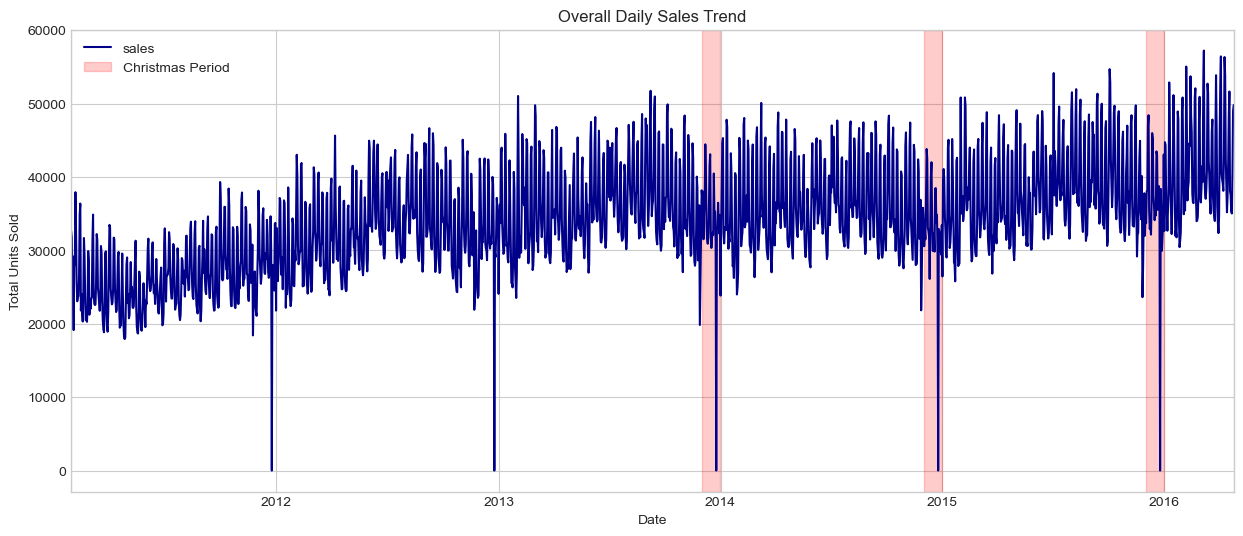

  Plotting weekly sales seasonality...


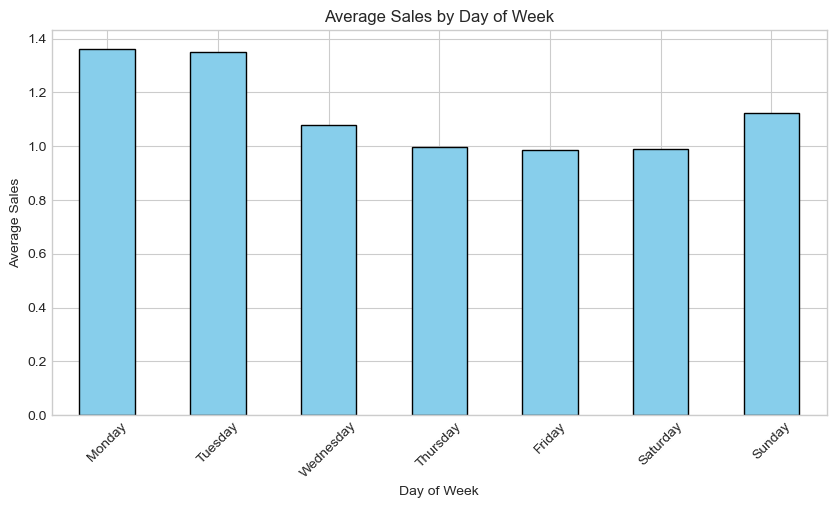

  Plotting sales comparison by store...


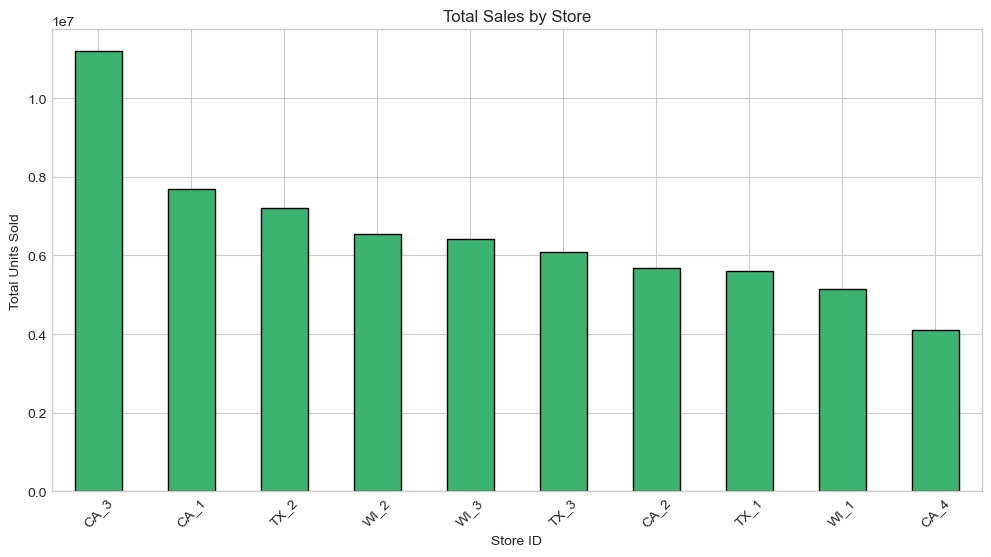

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Generating EDA Visualizations ---")

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')

# 1. Overall Daily Sales Trend
print("  Plotting overall daily sales trend...")
daily_sales = df.groupby('date')['sales'].sum()
daily_sales.index = pd.to_datetime(daily_sales.index)

plt.figure(figsize=(15, 6))
daily_sales.plot(title='Overall Daily Sales Trend', color='darkblue')
plt.ylabel('Total Units Sold')
plt.xlabel('Date')
plt.axvspan(xmin=pd.to_datetime('2013-12-01'), xmax=pd.to_datetime('2013-12-31'), color='red', alpha=0.2, label='Christmas Period')
plt.axvspan(xmin=pd.to_datetime('2014-12-01'), xmax=pd.to_datetime('2014-12-31'), color='red', alpha=0.2)
plt.axvspan(xmin=pd.to_datetime('2015-12-01'), xmax=pd.to_datetime('2015-12-31'), color='red', alpha=0.2)
plt.legend()
plt.show()

# 2. Weekly Sales Seasonality
print("  Plotting weekly sales seasonality...")
weekly_sales = df.groupby('wday')['sales'].mean()
weekday_map = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
weekly_sales.index = weekly_sales.index.map(weekday_map)
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales = weekly_sales.reindex(ordered_days)

plt.figure(figsize=(10, 5))
weekly_sales.plot(kind='bar', title='Average Sales by Day of Week', color='skyblue', edgecolor='black')
plt.ylabel('Average Sales')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.show()

# 3. Sales Comparison by Store
print("  Plotting sales comparison by store...")
store_sales = df.groupby('store_id')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
store_sales.plot(kind='bar', title='Total Sales by Store', color='mediumseagreen', edgecolor='black')
plt.ylabel('Total Units Sold')
plt.xlabel('Store ID')
plt.xticks(rotation=45)
plt.show()


In [5]:
print("\n--- Step 3: Training Models ---")

features = [
    'item_id_freq', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'wday', 'month', 'year',
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI',
    'sell_price',
    'sales_lag_7', 'sales_lag_14', 'sales_lag_28',
    'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28'
]

train_df = df[df['d'] <= 1913].copy()

params = {
    'objective': 'tweedie',
    'metric': 'rmse',
    'device': 'gpu',  # Remove or set to 'cpu' if you don't have GPU
    'max_bin': 63,
    'learning_rate': 0.05,
    'num_leaves': 128,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'tweedie_variance_power': 1.1,
    'seed': 42,
    'verbosity': -1,
}

categorical_features = [
    'dept_id', 'cat_id', 'store_id', 'state_id',
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'
]

models = {}
for store in tqdm(sales['store_id'].cat.categories, desc="Training per store"):
    print(f"\n▶▶▶ Training model for store: {store} ...")
    df_store = train_df[train_df['store_id'] == store]
    train_set = lgb.Dataset(
        df_store[features],
        label=df_store['sales'],
        categorical_feature=categorical_features,
        free_raw_data=False
    )
    model = lgb.train(
        params,
        train_set,
        num_boost_round=1000,
        callbacks=[lgb.log_evaluation(period=100)]
    )
    models[store] = model
    print(f"  ✔️ Store {store} model trained.")



--- Step 3: Training Models ---


Training per store:   0%|          | 0/10 [00:00<?, ?it/s]


▶▶▶ Training model for store: CA_1 ...
  ✔️ Store CA_1 model trained.

▶▶▶ Training model for store: CA_2 ...
  ✔️ Store CA_2 model trained.

▶▶▶ Training model for store: CA_3 ...
  ✔️ Store CA_3 model trained.

▶▶▶ Training model for store: CA_4 ...
  ✔️ Store CA_4 model trained.

▶▶▶ Training model for store: TX_1 ...
  ✔️ Store TX_1 model trained.

▶▶▶ Training model for store: TX_2 ...
  ✔️ Store TX_2 model trained.

▶▶▶ Training model for store: TX_3 ...
  ✔️ Store TX_3 model trained.

▶▶▶ Training model for store: WI_1 ...
  ✔️ Store WI_1 model trained.

▶▶▶ Training model for store: WI_2 ...
  ✔️ Store WI_2 model trained.

▶▶▶ Training model for store: WI_3 ...
  ✔️ Store WI_3 model trained.


In [6]:
pip install shap


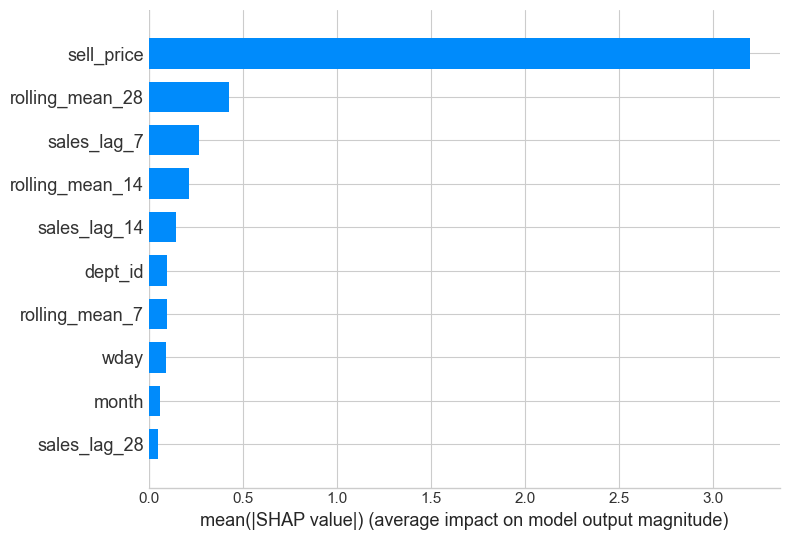

In [7]:
import shap

# Pick one store to explain, e.g., 'CA_1'
store_to_explain = 'CA_1'
model = models[store_to_explain]
df_store = train_df[train_df['store_id'] == store_to_explain]
X = df_store[features]

# Sample 100 rows for faster SHAP computation
X_sample = X.sample(n=100, random_state=42)

# Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Display SHAP summary plot for top 10 features
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=10)
